### Imports Here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

### Read the Dataset

In [2]:
%%time
df_construction = pd.read_csv('US_Constructions_Dec21.csv')

CPU times: total: 54.4 s
Wall time: 1min


### Attribute Information (Ref: https://arxiv.org/abs/2209.06813)

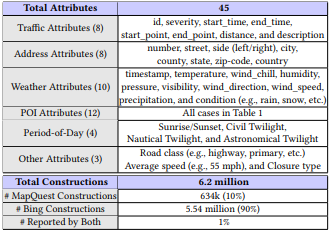

In [3]:
# -------------------------------------Memory Usage of Dataset-------------------------------------
# df_construction.info(memory_usage='deep')
df_construction.memory_usage(deep=True)

Index                          132
ID                       406171965
Severity                  49365016
Start_Time               486660038
End_Time                 486660038
Start_Lat                 49365016
Start_Lng                 49365016
End_Lat                   49365016
End_Lng                   49365016
Distance(mi)              49365016
Description              902148692
Number                    49365016
Street                   421014285
Side                     357896366
City                     405743147
County                   398347105
State                    364066993
Zipcode                  395163839
Country                  364066993
Timezone                 414078959
Airport_Code             375948336
Weather_Timestamp        465281068
Temperature(F)            49365016
Wind_Chill(F)             49365016
Humidity(%)               49365016
Pressure(in)              49365016
Visibility(mi)            49365016
Wind_Direction           363555778
Wind_Speed(mph)     

#### Observations:
1. As expected columns with dtypes as object consume highest memory followed by int/float and then bool dtypes.
2. We will reduce memory usage in the feature engineering/transformation phase.

### Memory Usage Analysis and Optimization

#### Categorical columns

In [4]:
# ?pd.select_dtypes
categorical_columns = [i for i in df_construction.select_dtypes(include='object').columns]
print(categorical_columns)


['ID', 'Start_Time', 'End_Time', 'Description', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [5]:
%%time
# Drop column 'ID' as it need not be converted to categorical
categorical_columns.remove('ID')
categorical_columns.remove('Start_Time')
categorical_columns.remove('End_Time')
categorical_columns.remove('Weather_Timestamp')
df_construction[categorical_columns] = df_construction[categorical_columns].astype('category')

CPU times: total: 32.7 s
Wall time: 33.4 s


We have changed the dtype of object columns to category to optimize the memory usage

In [6]:
%%time
# Astronomical_Twilight - 372929534(Original)  6170857(Optimized)
# 486660038  291105644
# 566120817  406171965
df_construction.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170627 entries, 0 to 6170626
Data columns (total 47 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     object  
 1   Severity               int64   
 2   Start_Time             object  
 3   End_Time               object  
 4   Start_Lat              float64 
 5   Start_Lng              float64 
 6   End_Lat                float64 
 7   End_Lng                float64 
 8   Distance(mi)           float64 
 9   Description            category
 10  Number                 float64 
 11  Street                 category
 12  Side                   category
 13  City                   category
 14  County                 category
 15  State                  category
 16  Zipcode                category
 17  Country                category
 18  Timezone               category
 19  Airport_Code           category
 20  Weather_Timestamp      object  
 21  Temperature(F)         float64 

#### Memory optimized from 8.8 GB to 2.9 GB for our dataframe by handling categorical data

#### Datetime features - 'Start_Time', 'End_Time', 'Weather_Timestamp'
1. We have Weather_Condition as one column we may drop Weather_Timestamp as both are very similar
2. Also converted the 'Start_Time' and 'End_Time' features to datetime objects to optimize the memory usage
3. Created 3 more features 'duration_year', 'duration_months', 'duration_hours' from the existing columns which will help us understand the duration of work which has been put in 

In [7]:
%%time
# to_datetime()
df_construction['Start_Time'] = pd.to_datetime(df_construction['Start_Time'])
df_construction['End_Time'] = pd.to_datetime(df_construction['End_Time'])

# Year
df_construction['start_year'] = df_construction['Start_Time'].dt.year
df_construction['end_year'] = df_construction['End_Time'].dt.year
df_construction['duration_year'] = df_construction['end_year'] - df_construction['start_year']

# Month
df_construction['start_month'] = df_construction['Start_Time'].dt.month
df_construction['end_month'] = df_construction['End_Time'].dt.month
df_construction['duration_months'] = df_construction['end_month'] - df_construction['start_month']
df_construction.loc[df_construction['duration_months']<0,'duration_months']+=12 # Account for change in year

# Hour
df_construction['start_hour'] = df_construction['Start_Time'].dt.hour
df_construction['end_hour'] = df_construction['End_Time'].dt.hour
df_construction['duration_hours'] = df_construction['end_hour'] - df_construction['start_hour']
df_construction.loc[df_construction['duration_hours']<0,'duration_hours']+=24  # Account for cahnge in day


CPU times: total: 11.7 s
Wall time: 12.7 s


#### Memory further optimized to 2.5 GB (Post handling datetime features)

In [8]:
# After converting object to datetimes and creating new features like duration of work in months,hours,year
df_construction.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170627 entries, 0 to 6170626
Data columns (total 56 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            category      
 10  Number                 float64       
 11  Street                 category      
 12  Side                   category      
 13  City                   category      
 14  County                 category      
 15  State                  category      
 16  Zipcode                category      
 17  Country                category      
 18  Timezone              

In [9]:
# df_construction.dtypes
df_construction[['duration_year','duration_months','duration_hours']].tail()

,duration_year,duration_months,duration_hours
6170622,1,9,15
6170623,0,0,8
6170624,0,0,5
6170625,0,0,2
6170626,0,0,6


In [10]:
# df_construction[df_construction['duration_months']<0]['Severity'].value_counts()
df_construction[df_construction['duration_months']<0]

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Astronomical_Twilight,start_year,end_year,duration_year,start_month,end_month,duration_months,start_hour,end_hour,duration_hours


In [11]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022)]['Severity'].value_counts()

2    2974931
4     192036
3      48017
1      11895
Name: Severity, dtype: int64

### EDA (Exploratory Data Analysis)

In [12]:
df_construction.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Astronomical_Twilight,start_year,end_year,duration_year,start_month,end_month,duration_months,start_hour,end_hour,duration_hours
0,C-1,4,2019-04-05 16:00:00,2020-09-29 11:53:57,32.838360,-93.152378,32.850740,-93.164388,1.103497,Construction on LA-534 WB near EDMONDS LOOP Ro...,...,Day,2019,2020,1,4,9,5,16,11,19
1,C-2,2,2021-11-12 07:59:00,2021-11-12 08:22:30,30.221331,-92.008625,30.216642,-92.003809,0.433173,Slow traffic on US-90 E from US-167/Louisiana ...,...,Day,2021,2021,0,11,11,0,7,8,1
2,C-3,2,2021-10-12 07:17:30,2021-10-12 09:18:55,39.653153,-104.910224,39.653120,-104.913838,0.192266,Slow traffic on CO-30 from S Tamarac Dr (E Ham...,...,Day,2021,2021,0,10,10,0,7,9,2
3,C-4,4,2021-02-10 02:46:10,2021-02-17 23:59:00,33.961506,-118.029339,33.961919,-118.029082,0.032112,Closed road from Whittier to College Ave due t...,...,Night,2021,2021,0,2,2,0,2,23,21
4,C-5,2,2020-09-24 15:58:00,2020-09-25 21:04:54,40.008734,-79.599696,40.022822,-79.595703,0.996057,Construction on US-119 NB near SAMPSON ST Allo...,...,Day,2020,2020,0,9,9,0,15,21,6


In [13]:
df_construction.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'start_year', 'end_year', 'duration_year',
       'start_month', 'end_month', 'duration_months', 'start_hour', 'end_hour',
       'duration_hours'],
      dtype='object')

In [14]:
df_construction.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),...,Precipitation(in),start_year,end_year,duration_year,start_month,end_month,duration_months,start_hour,end_hour,duration_hours
count,6.170627e+06,6.170627e+06,6.170627e+06,5.536579e+06,5.536579e+06,6.170627e+06,3.495798e+06,6.055233e+06,5.394061e+06,6.048067e+06,...,5.248183e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06,6.170627e+06
mean,2.253898e+00,3.729715e+01,-9.144676e+01,3.717219e+01,-9.134230e+01,1.259217e+00,5.941666e+03,6.318595e+01,6.199467e+01,6.334873e+01,...,3.773323e-03,2.020121e+03,2.020140e+03,1.839489e-02,7.442430e+00,7.806375e+00,4.589960e-01,1.176618e+01,1.264894e+01,6.060200e+00
std,6.296634e-01,5.515846e+00,1.611645e+01,5.586545e+00,1.592293e+01,3.977114e+00,1.291896e+04,1.795553e+01,2.023514e+01,2.281208e+01,...,8.961252e-02,1.228128e+00,1.218831e+00,1.751909e-01,3.179254e+00,3.188599e+00,1.575459e+00,5.958165e+00,6.612722e+00,5.794917e+00
min,1.000000e+00,2.088731e+01,-1.579783e+02,2.088772e+01,-1.579768e+02,0.000000e+00,1.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,...,0.000000e+00,2.016000e+03,2.016000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.349486e+01,-1.049825e+02,3.348016e+01,-1.049599e+02,1.324791e-01,6.690000e+02,5.100000e+01,5.000000e+01,4.700000e+01,...,0.000000e+00,2.020000e+03,2.020000e+03,0.000000e+00,5.000000e+00,5.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,1.000000e+00
50%,2.000000e+00,3.925449e+01,-8.571116e+01,3.919636e+01,-8.566375e+01,3.249112e-01,2.408000e+03,6.600000e+01,6.600000e+01,6.500000e+01,...,0.000000e+00,2.021000e+03,2.021000e+03,0.000000e+00,8.000000e+00,8.000000e+00,0.000000e+00,1.200000e+01,1.400000e+01,5.000000e+00
75%,2.000000e+00,4.105826e+01,-7.886149e+01,4.097113e+01,-7.915132e+01,1.031883e+00,6.799000e+03,7.700000e+01,7.700000e+01,8.200000e+01,...,0.000000e+00,2.021000e+03,2.021000e+03,0.000000e+00,1.000000e+01,1.000000e+01,0.000000e+00,1.600000e+01,1.800000e+01,1.000000e+01
max,4.000000e+00,4.900083e+01,-6.706635e+01,4.900701e+01,-6.706634e+01,6.877400e+02,9.610510e+05,1.960000e+02,1.960000e+02,1.000000e+02,...,2.400000e+01,2.021000e+03,2.022000e+03,5.000000e+00,1.200000e+01,1.200000e+01,1.100000e+01,2.300000e+01,2.300000e+01,2.300000e+01


#### 1. Target Feature: Severity

In [15]:
# 'Severity'
df_construction['Severity'].value_counts()

2    5121363
4     598342
3     410474
1      40448
Name: Severity, dtype: int64

<Axes: xlabel='Severity', ylabel='count'>

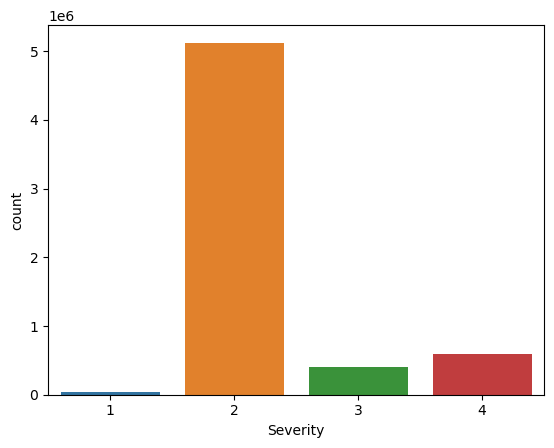

In [16]:
# Count plot to check balance in the classes
#sns.countplot(data=df_construction['Severity'],x='Severity')
sns.countplot(x=df_construction['Severity'])

The values of the target feature 'Severity' are heavily imbalanced, with Severity = 2 being the most common value

#### 2. Statewise Severity Analysis
1. Check imbalance in dataset

In [17]:
df_construction['State'].value_counts()

FL    771431
NY    574601
CA    556830
PA    490502
AZ    382709
TX    340406
IL    268764
CO    257245
OH    151801
NJ    148116
IN    147094
MI    136128
VA    134877
WA    133216
GA    130951
OR    128539
MD     94847
MN     89894
LA     89791
NC     75439
WI     74346
CT     72516
MA     68525
OK     67466
ID     64859
IA     62854
AR     61977
KS     56653
SC     50868
MO     44666
TN     43993
AL     37092
KY     35065
DE     34937
NM     34239
MT     30575
UT     26862
NV     25122
NE     25112
WY     19212
MS     18834
ME     18095
DC     17971
RI     17651
SD     17175
WV     16983
NH     12076
VT      6680
ND      5030
HI        12
Name: State, dtype: int64

Checking the Severity of the top 4 states with highest values

In [18]:
df_construction[df_construction['State']=='PA']['Severity'].value_counts(normalize=True)*100
# NY: 2 = 87%, 4 = 6.9%, 3 = 5%, 1 = 0.4% 
# CA: 2 = 70%, 4 = 16%, 3 = 12%, 1 = 0.6% 
# FL: 2 = 92%, 4 = 4.1%, 3 = 2.4%, 1 = 0.48% 
# PA: 2 = 86%, 4 = 9.5%, 3 = 3.59%, 1 = 0.62%

2    86.248170
4     9.541245
3     3.589384
1     0.621200
Name: Severity, dtype: float64

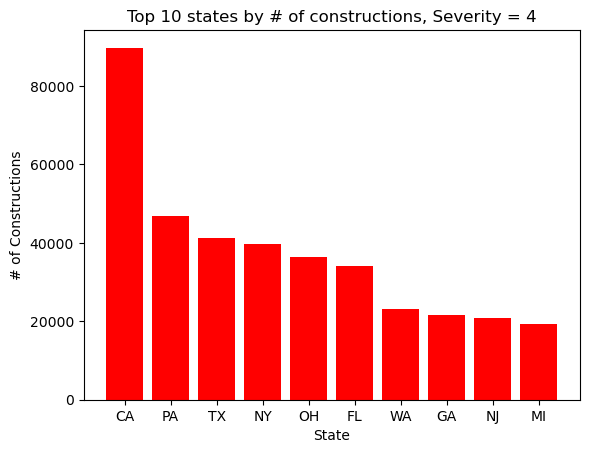

In [19]:
state_df_s4 = pd.DataFrame(df_construction[df_construction["Severity"] == 4]['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})
top_10_states_s4 = pd.DataFrame(state_df_s4.head(10))
plt.bar(top_10_states_s4["State"], top_10_states_s4["Cases"], color = 'red')
plt.title('Top 10 states by # of constructions, Severity = 4')
plt.xlabel("State")
plt.ylabel("# of Constructions")
plt.show()

In [20]:
state_df_s4.head()

,State,Cases
0,CA,89784
1,PA,46800
2,TX,41242
3,NY,39766
4,OH,36515


In [21]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

Following is the mean of road closures between 2021 and 2022 for CA

In [22]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['duration_hours'].mean()

6.550417456838165

Following is CA state road closures between 2021 and 2022 with Severity value_counts()

In [23]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

CA state road closures between 2021 and 2022 with Severity value_counts() and duration of construction greater than 2 months

In [24]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA') & (df_construction['duration_months'] > 2)]['Severity'].value_counts()

2    11041
4     1945
3       24
1       22
Name: Severity, dtype: int64

In [25]:
# ?pd.DataFrame.copy
#df_copy = df_construction.copy(deep=True)

### We are proceeding with the samples of California state (CA) for this project

In [26]:
df_construction_ca = df_construction[df_construction['State']=='CA']

In [27]:
df_construction_ca.shape

(556830, 56)

Data samples for CA dataset from the year 2021 to 2022

In [28]:
df_construction_ca_recent = df_construction_ca[(df_construction_ca['start_year']>=2021) & (df_construction_ca['end_year']<=2022)]

In [29]:
df_construction_ca_recent.shape

(203015, 56)

In [30]:
df_construction_ca_recent['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

### EDA Phase 2

In [31]:
df_construction_ca_recent.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Astronomical_Twilight,start_year,end_year,duration_year,start_month,end_month,duration_months,start_hour,end_hour,duration_hours
3,C-4,4,2021-02-10 02:46:10,2021-02-17 23:59:00,33.961506,-118.029339,33.961919,-118.029082,0.032112,Closed road from Whittier to College Ave due t...,...,Night,2021,2021,0,2,2,0,2,23,21
16,C-17,2,2021-10-23 07:28:00,2021-10-23 07:48:00,34.579902,-117.943117,34.580006,-117.934054,0.515617,Stationary traffic from 90th St (Palmdale Blvd...,...,Day,2021,2021,0,10,10,0,7,7,0
54,C-55,2,2021-04-16 08:00:00,2021-04-16 17:45:00,39.395881,-121.084068,39.394888,-121.084600,0.074258,Construction on CA-49 SB near MOONSHINE RD Exp...,...,Day,2021,2021,0,4,4,0,8,17,9
88,C-90,3,2021-12-22 00:00:00,2021-12-22 02:00:00,33.947762,-118.279129,NaN,NaN,0.910000,Entry ramp to I-110 Northbound from Century Bl...,...,Night,2021,2021,0,12,12,0,0,2,2
121,C-125,2,2021-12-11 15:00:00,2021-12-12 03:20:40,33.970896,-117.846876,33.972326,-117.845696,0.119724,Roadwork on Brea Canyon Rd (CA-57) from Diamon...,...,Day,2021,2021,0,12,12,0,15,3,12


In [32]:
df_construction_ca_recent.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203015 entries, 3 to 6170614
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     203015 non-null  object        
 1   Severity               203015 non-null  int64         
 2   Start_Time             203015 non-null  datetime64[ns]
 3   End_Time               203015 non-null  datetime64[ns]
 4   Start_Lat              203015 non-null  float64       
 5   Start_Lng              203015 non-null  float64       
 6   End_Lat                173023 non-null  float64       
 7   End_Lng                173023 non-null  float64       
 8   Distance(mi)           203015 non-null  float64       
 9   Description            203015 non-null  category      
 10  Number                 93904 non-null   float64       
 11  Street                 203015 non-null  category      
 12  Side                   203015 non-null  cat

In [33]:
df_construction_ca_recent.isnull().sum()

ID                            0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                   29992
End_Lng                   29992
Distance(mi)                  0
Description                   0
Number                   109111
Street                        0
Side                          0
City                         10
County                        0
State                         0
Zipcode                     137
Country                       0
Timezone                    140
Airport_Code                582
Weather_Timestamp          4135
Temperature(F)             4958
Wind_Chill(F)              6084
Humidity(%)                5194
Pressure(in)               4424
Visibility(mi)             4666
Wind_Direction             5594
Wind_Speed(mph)            5593
Precipitation(in)         17214
Weather_Condition          5105
Amenity                       0
Bump    

### 1. Analyzing the target feature 'Severity' with 'Description'

In [34]:
# Closed Road, Full closure  severity = 4
# Road closed, entry ramp, one lane closed, intermittent lane closure  severity = 3
# stationary traffic, roadwork, construction, slow traffic  severity = 2
df_construction_ca_recent[df_construction_ca_recent['Severity']==1]['Description'].tail(10)

# So when roads are closed intermittently the severity is not high.
# Also when roads closed it could indicate severity = 3 or 2 and not 1


6137643    Road closed due to utility work on Ocean View ...
6142045    Road closed intermittently due to paving repai...
6144197    Road closed due to construction during the day...
6145504    Road closed intermittently due to resurfacing ...
6147286    Road closed due to construction work on Garden...
6153533    Road closed intermittently due to resurfacing ...
6155371    Road closed intermittently due to resurfacing ...
6156655    Road closed due to construction work on Navill...
6156773    Road closed due to bridge maintenance work on ...
6166022    Intermittent lane closures and road closed int...
Name: Description, dtype: category
Categories (1578183, object): [' 03:30 PM right lane closure', ' CONSTRUCTION AHEAD  SIGN IS CAUSING A VIS HA..., ' Meadow Street; take a right onto Freight Str..., ' SEMI W/ TL PART 1125 ON FOG LINE // BO TIRE ..., ..., 'waterville I-95 South between mile 130 to 129..., 'work is beingon done on the interstate to rep..., 'working behind barrier walls. C

In [35]:
df_construction_ca_recent[df_construction_ca_recent['Description'].str.contains('Road closed due')]['Severity'].value_counts()
# We see that for road closed due to some reason, we have few misclassified rows as 1

1    656
3    468
4    153
2     23
Name: Severity, dtype: int64

In [36]:
df_construction_ca_recent[df_construction_ca_recent['Description'].str.contains('intermittently')]['Severity'].value_counts()

1    759
3     50
2      6
4      4
Name: Severity, dtype: int64

In [37]:
df_construction_ca_recent[df_construction_ca_recent['Description'].str.contains('maintenance')]['Severity'].value_counts()

3    3621
2    2774
1     186
4      59
Name: Severity, dtype: int64

In [38]:
df_construction_ca_recent[df_construction_ca_recent['Description'].str.contains('Full closure')]['Severity'].value_counts()

4    6318
Name: Severity, dtype: int64

### 1. Analyzing the target feature 'Severity' with 'Weather_Condition'

In [39]:
df_construction_ca_recent['Weather_Condition'].value_counts()

Fair                      123067
Cloudy                     27889
Mostly Cloudy              14244
Partly Cloudy               9313
Haze                        6840
                           ...  
Heavy Freezing Drizzle         0
Heavy Drizzle / Windy          0
Heavy Drizzle                  0
Patches of Fog / Windy         0
Light Snow Grains              0
Name: Weather_Condition, Length: 111, dtype: int64

In [40]:
# df_construction_ca_recent[df_construction_ca_recent['Weather_Condition']
df_construction_ca_recent.groupby(['Weather_Condition'])['Severity'].count()
# pd.Series.remove_unused_categories(df_construction_ca_recent['Weather_Condition'])


Weather_Condition
Blowing Dust               15
Blowing Dust / Windy       18
Blowing Sand                0
Blowing Snow                0
Blowing Snow / Windy        0
                           ..
Tornado                     0
Widespread Dust            14
Widespread Dust / Windy    16
Wintry Mix                 38
Wintry Mix / Windy          5
Name: Severity, Length: 111, dtype: int64

In [41]:
df_construction_ca_recent[df_construction_ca_recent['Weather_Condition'] == 'Cloudy']['Severity'].value_counts()

2    21053
4     4282
3     2253
1      301
Name: Severity, dtype: int64

In [42]:
df_construction_ca_recent[df_construction_ca_recent['Weather_Condition'] == 'Widespread Dust']['Severity'].value_counts()

2    7
4    7
Name: Severity, dtype: int64

In [43]:
df_construction_ca_recent[df_construction_ca_recent['Weather_Condition'] == 'Wintry Mix']['Severity'].value_counts()

2    38
Name: Severity, dtype: int64

#### Categorical columns

In [44]:
categorical_columns = [i for i in df_construction_ca_recent.select_dtypes(include='category').columns]
print('Categorical Columns:',categorical_columns)

Categorical Columns: ['Description', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [45]:
# df_construction_ca_recent['Nautical_Twilight'].value_counts()
# df_construction_ca_recent['Civil_Twilight'].value_counts()
df_construction_ca_recent['Astronomical_Twilight'].value_counts()

Day      141644
Night     61357
Name: Astronomical_Twilight, dtype: int64

In [46]:
# Civil_Twilight
df_construction_ca_recent[df_construction_ca_recent['Severity']==4]['Civil_Twilight'].value_counts()

Night    18692
Day      10952
Name: Civil_Twilight, dtype: int64

In [47]:
# Civil_Twilight
df_construction_ca_recent[df_construction_ca_recent['Severity']==4]['Nautical_Twilight'].value_counts()

Night    16906
Day      12738
Name: Nautical_Twilight, dtype: int64

In [48]:
# Civil_Twilight
df_construction_ca_recent[df_construction_ca_recent['Severity']==4]['Astronomical_Twilight'].value_counts()

Night    14931
Day      14713
Name: Astronomical_Twilight, dtype: int64

#### Observation
From the above code, we can observe that: 
1. Work during night time is seen to be more severe than day time

In [49]:
#### Top 10 cities in California with road closures of highest severity
city_df_ca = pd.DataFrame(df_construction_ca[df_construction_ca['Severity']==4]['City'].value_counts()).reset_index().rename(columns={'index':'City','City':'Cases'})
city_df_ca.head()

,City,Cases
0,Los Angeles,11147
1,San Diego,3514
2,Westminster,2274
3,Fountain Valley,1989
4,San Francisco,1844


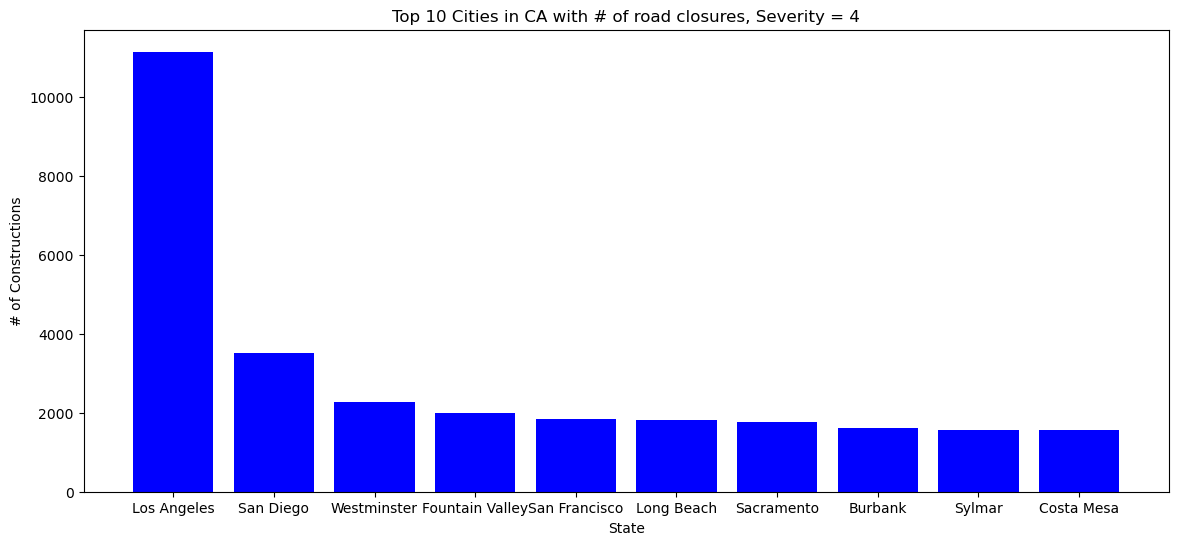

In [50]:
top_10_cities_ca = pd.DataFrame(city_df_ca.head(10))
plt.figure(figsize=(14,6))
plt.bar(top_10_cities_ca['City'], top_10_cities_ca['Cases'],color='blue')
plt.title('Top 10 Cities in CA with # of road closures, Severity = 4')
plt.xlabel('State')
plt.ylabel('# of Constructions')
# plt.xticks(rotation=)
plt.show()
# state_df_s4 = pd.DataFrame(df_construction[df_construction["Severity"] == 4]['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})

Observation: Los Angeles and San Diego are the cities with most number of high severity road closures

### Initial Feature Selection/Elimination
1. We select Civil Twilight out of ['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
2. We drop ['Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone']
3. We drop Weather_Condition as it has a total of 111 categories

In [51]:
df_construction_ca_recent.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'start_year', 'end_year', 'duration_year',
       'start_month', 'end_month', 'duration_months', 'start_hour', 'end_hour',
       'duration_hours'],
      dtype='object')

In [52]:
# We are dropping the geography based columns + the columns mentioned above.
features_to_drop = ['ID','Start_Time','End_Time','Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Number','Street',
                    'Side','City','County','State','Zipcode','Country','Timezone','start_year','end_year','duration_year',
                    'start_month','end_month','start_hour','end_hour', 'Nautical_Twilight','Astronomical_Twilight','Wind_Chill(F)','Wind_Direction','Airport_Code','Weather_Timestamp',
                    'Wind_Speed(mph)','Weather_Condition','Sunrise_Sunset']
# Weather_Condition
# 'duration_hours'
# 'Civil_Twilight'(try)
# 'Pressure(in)'

In [53]:
# ---------------------------------------Encode Categorical Values-----------------------------


In [54]:
df_construction_ca_recent.drop(features_to_drop,axis=1)

,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Precipitation(in),Amenity,Bump,Crossing,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,duration_months,duration_hours
3,4,0.032112,54.0,83.0,29.92,9.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Night,0,21
16,2,0.515617,NaN,NaN,NaN,NaN,NaN,False,False,False,...,False,False,False,False,False,True,False,Day,0,0
54,2,0.074258,55.0,38.0,26.73,10.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Day,0,9
88,3,0.910000,53.0,86.0,30.05,9.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Night,0,2
121,2,0.119724,64.0,21.0,29.03,10.0,NaN,False,False,False,...,False,False,False,False,False,False,False,Day,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6170476,2,0.575311,47.0,71.0,30.05,10.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Night,0,10
6170564,3,0.630000,50.0,29.0,29.80,10.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Night,0,4
6170573,2,1.252609,34.0,100.0,27.63,10.0,0.02,False,False,False,...,False,False,False,False,False,False,False,Day,0,1
6170596,4,0.100457,35.0,87.0,28.38,10.0,0.00,False,False,False,...,False,False,False,False,False,False,False,Night,0,8


In [55]:
df_construction_ca_recent.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'start_year', 'end_year', 'duration_year',
       'start_month', 'end_month', 'duration_months', 'start_hour', 'end_hour',
       'duration_hours'],
      dtype='object')

### Handle Missing values

In [56]:
temp_df = df_construction_ca_recent.dropna(axis=0,thresh=50)

In [57]:
temp_df['Civil_Twilight']=pd.get_dummies(data = temp_df['Civil_Twilight'], drop_first=True)

C:\Users\ykulk\AppData\Local\Temp\ipykernel_11320\1966436248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Civil_Twilight']=pd.get_dummies(data = temp_df['Civil_Twilight'], drop_first=True)


In [58]:
# temp_df.shape
temp_df.drop(features_to_drop,axis=1,inplace=True)
# print(temp_df.isna().sum())
# print(temp_df['Severity'].value_counts())

C:\Users\ykulk\AppData\Local\Temp\ipykernel_11320\2125111642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop(features_to_drop,axis=1,inplace=True)


In [59]:
temp_df = temp_df.dropna()

In [60]:
# df_construction_ca_recent.isna().sum()
df_construction_ca_recent['Temperature(F)'].head(20)

3      54.0
16      NaN
54     55.0
88     53.0
121    64.0
187    71.0
202    57.0
203    95.0
204    43.0
209    60.0
229    34.0
237    67.0
281    61.0
346    45.0
363    64.0
369    91.0
416    63.0
454    62.0
557    71.0
594    50.0
Name: Temperature(F), dtype: float64

<Axes: title={'center': 'Correlation Analysis'}>

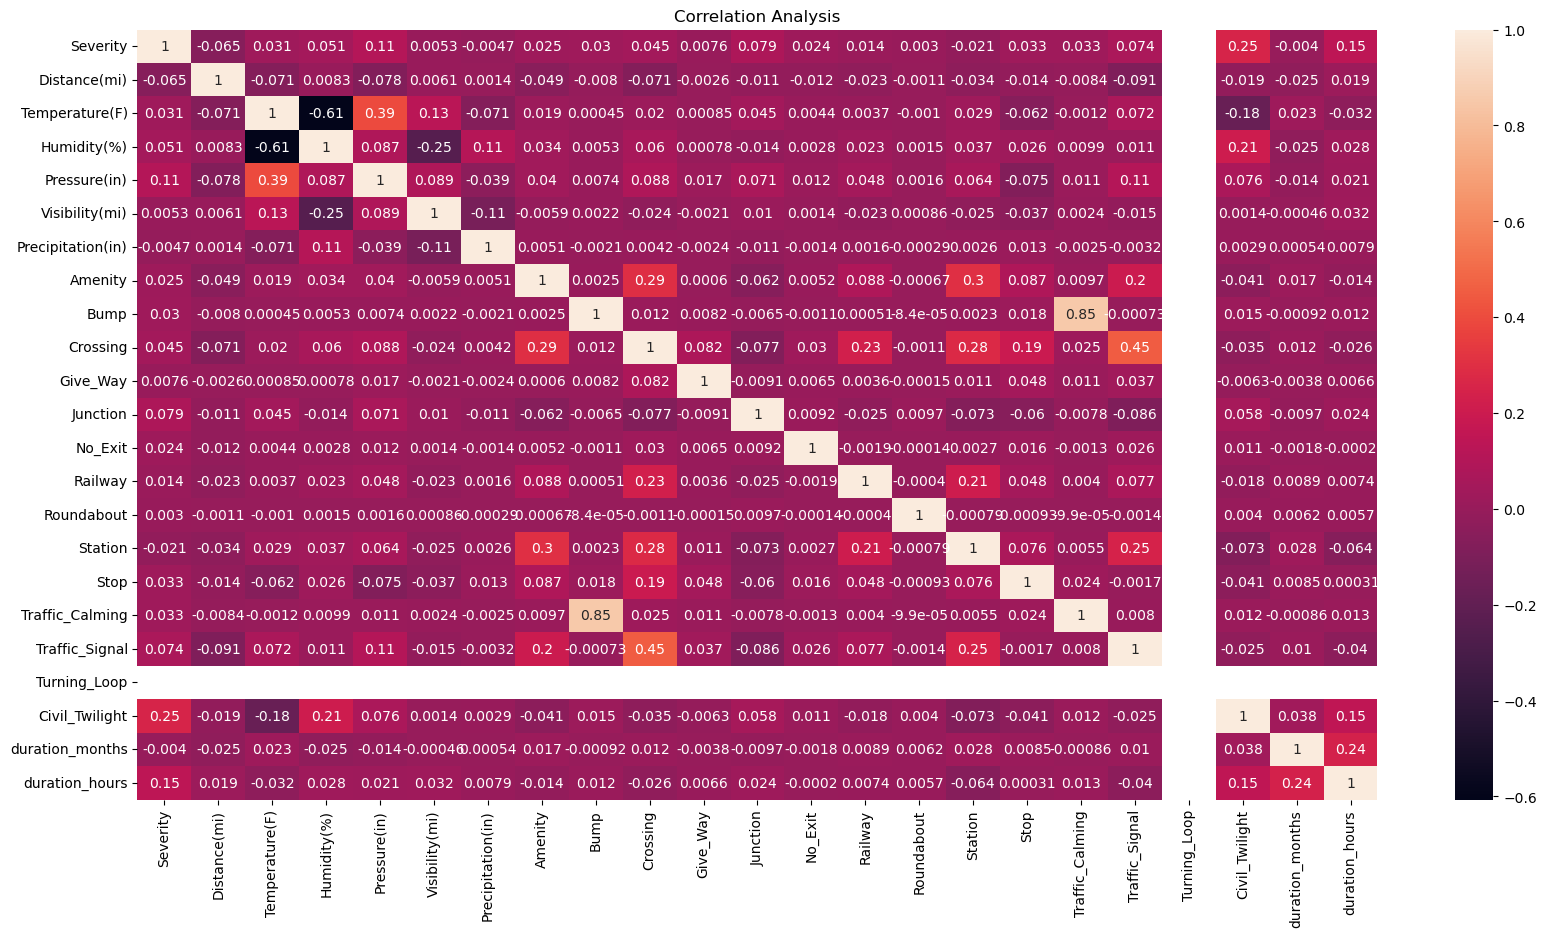

In [61]:
# ---------------------------------CORRELATION ANALYSIS---------------------------------
plt.figure(figsize=(20,10))
plt.title('Correlation Analysis')
sns.heatmap(temp_df.corr(),annot=True)
# df_construction_ca_recent

In [62]:
temp_df.corr()

,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Precipitation(in),Amenity,Bump,Crossing,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,duration_months,duration_hours
Severity,1.000000,-0.065244,0.030921,0.051078,0.105976,0.005281,-0.004685,0.024931,0.030241,0.044879,...,0.014342,0.002964,-0.021077,0.033277,0.033449,0.074326,NaN,0.250522,-0.003961,0.145882
Distance(mi),-0.065244,1.000000,-0.070704,0.008271,-0.078090,0.006132,0.001444,-0.048527,-0.008039,-0.070711,...,-0.022969,-0.001109,-0.033994,-0.013840,-0.008363,-0.091115,NaN,-0.019417,-0.025167,0.018620
Temperature(F),0.030921,-0.070704,1.000000,-0.606615,0.394614,0.131465,-0.071367,0.018612,0.000448,0.019827,...,0.003655,-0.001025,0.029478,-0.062415,-0.001187,0.071644,NaN,-0.175402,0.023038,-0.031724
Humidity(%),0.051078,0.008271,-0.606615,1.000000,0.087424,-0.247427,0.110076,0.033790,0.005296,0.059654,...,0.023284,0.001451,0.037258,0.026378,0.009854,0.010736,NaN,0.208023,-0.025276,0.028370
Pressure(in),0.105976,-0.078090,0.394614,0.087424,1.000000,0.088762,-0.039416,0.039692,0.007412,0.087723,...,0.047838,0.001563,0.063778,-0.075115,0.010626,0.106051,NaN,0.075598,-0.014320,0.021348
Visibility(mi),0.005281,0.006132,0.131465,-0.247427,0.088762,1.000000,-0.114546,-0.005933,0.002185,-0.023927,...,-0.022737,0.000856,-0.025480,-0.037068,0.002369,-0.015094,NaN,0.001402,-0.000459,0.031810
Precipitation(in),-0.004685,0.001444,-0.071367,0.110076,-0.039416,-0.114546,1.000000,0.005069,-0.002096,0.004180,...,0.001638,-0.000292,0.002602,0.013131,-0.002520,-0.003215,NaN,0.002869,0.000542,0.007934
Amenity,0.024931,-0.048527,0.018612,0.033790,0.039692,-0.005933,0.005069,1.000000,0.002477,0.291602,...,0.088306,-0.000668,0.302384,0.087455,0.009712,0.200374,NaN,-0.041357,0.016602,-0.014074
Bump,0.030241,-0.008039,0.000448,0.005296,0.007412,0.002185,-0.002096,0.002477,1.000000,0.012178,...,0.000509,-0.000084,0.002283,0.018147,0.850124,-0.000729,NaN,0.015005,-0.000916,0.011542
Crossing,0.044879,-0.070711,0.019827,0.059654,0.087723,-0.023927,0.004180,0.291602,0.012178,1.000000,...,0.225297,-0.001093,0.275589,0.191643,0.025150,0.448370,NaN,-0.034993,0.012309,-0.025823


C:\Users\ykulk\AppData\Local\Temp\ipykernel_11320\308170310.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_construction_ca_recent.corr(),annot=True)


<Axes: title={'center': 'Correlation Analysis'}>

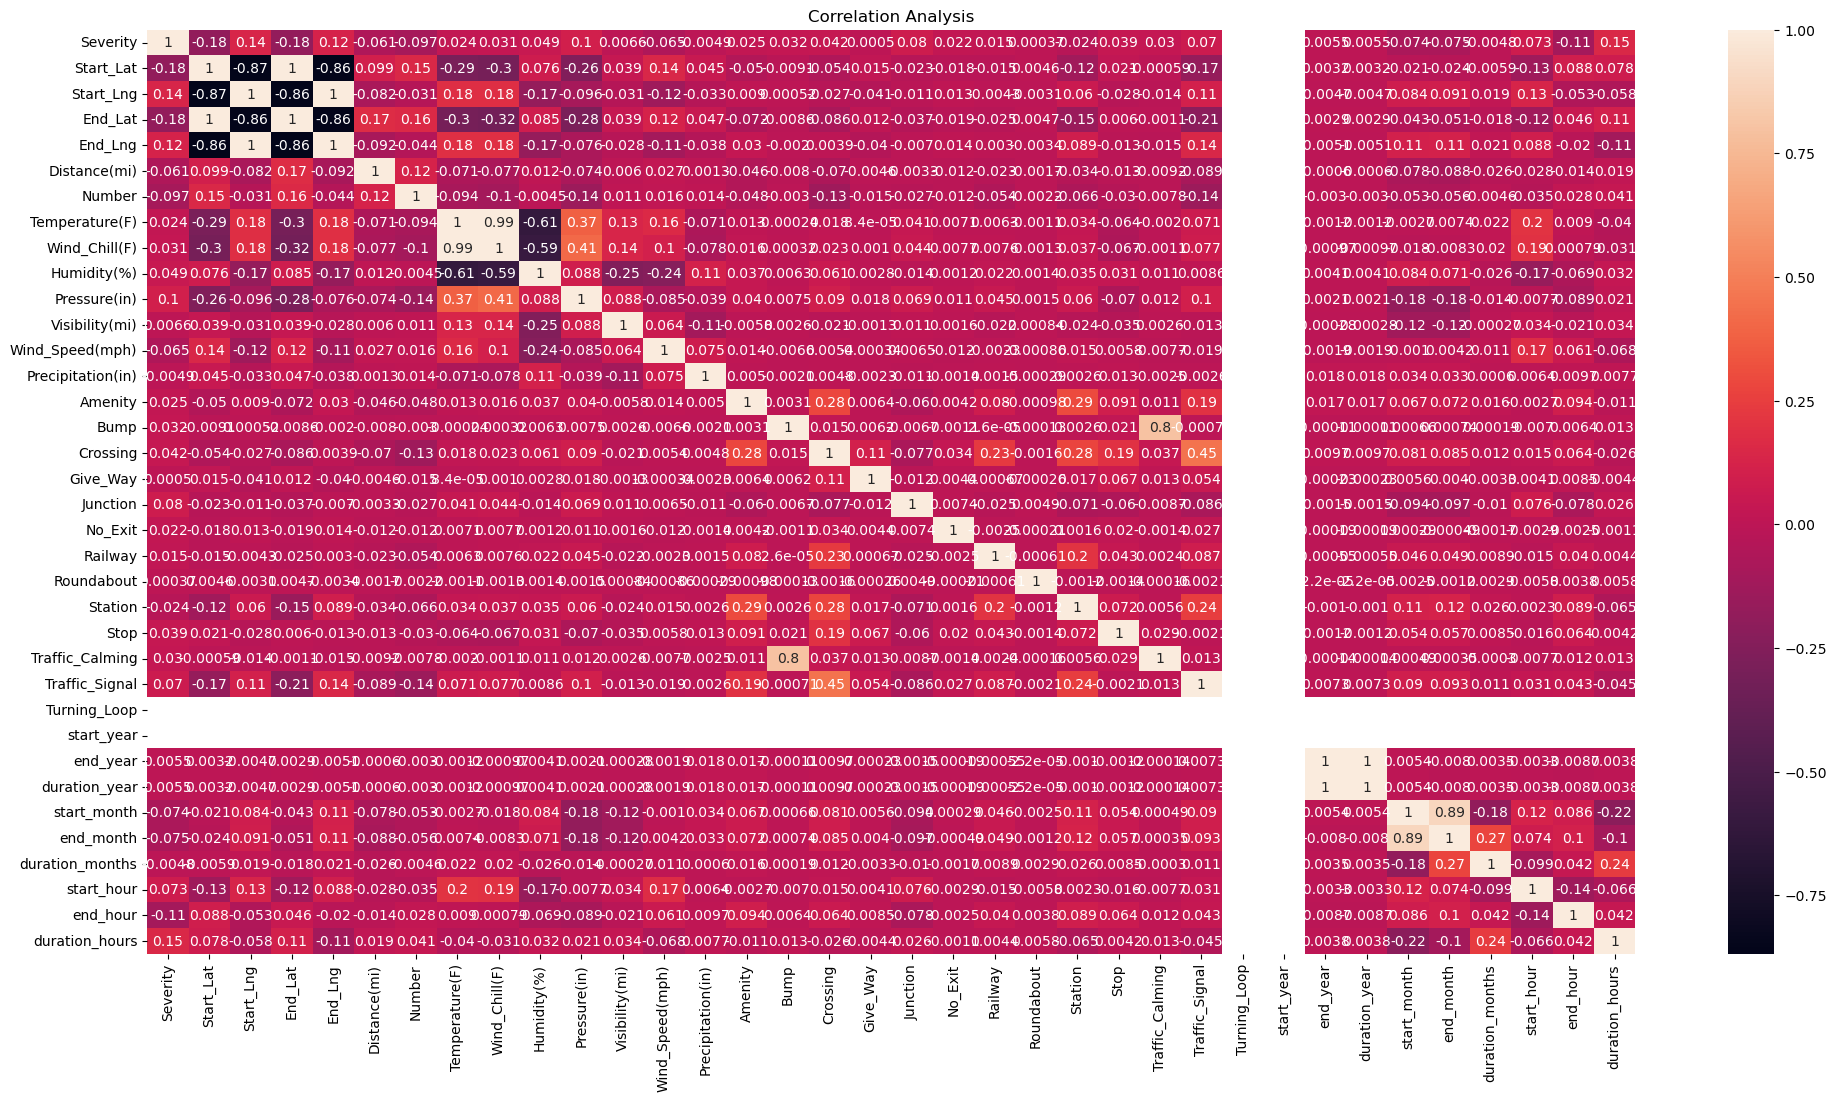

In [63]:
# ---------------------------------CORRELATION ANALYSIS---------------------------------
plt.figure(figsize=(24,12))
plt.title('Correlation Analysis')
sns.heatmap(df_construction_ca_recent.corr(),annot=True)


In [64]:
temp_df["Severity"] = temp_df["Severity"].apply(lambda x: 0 if x!=4 and x!=3 else 1)
X = temp_df.drop('Severity',axis=1)
y = temp_df['Severity']
temp_df["Severity"].value_counts()

0    146444
1     37820
Name: Severity, dtype: int64

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [66]:
# temp_df.isna().sum()
temp_df.shape

(184264, 23)

CPU times: total: 2min 25s
Wall time: 2min 28s


<Axes: xlabel='Importance', ylabel='Features'>

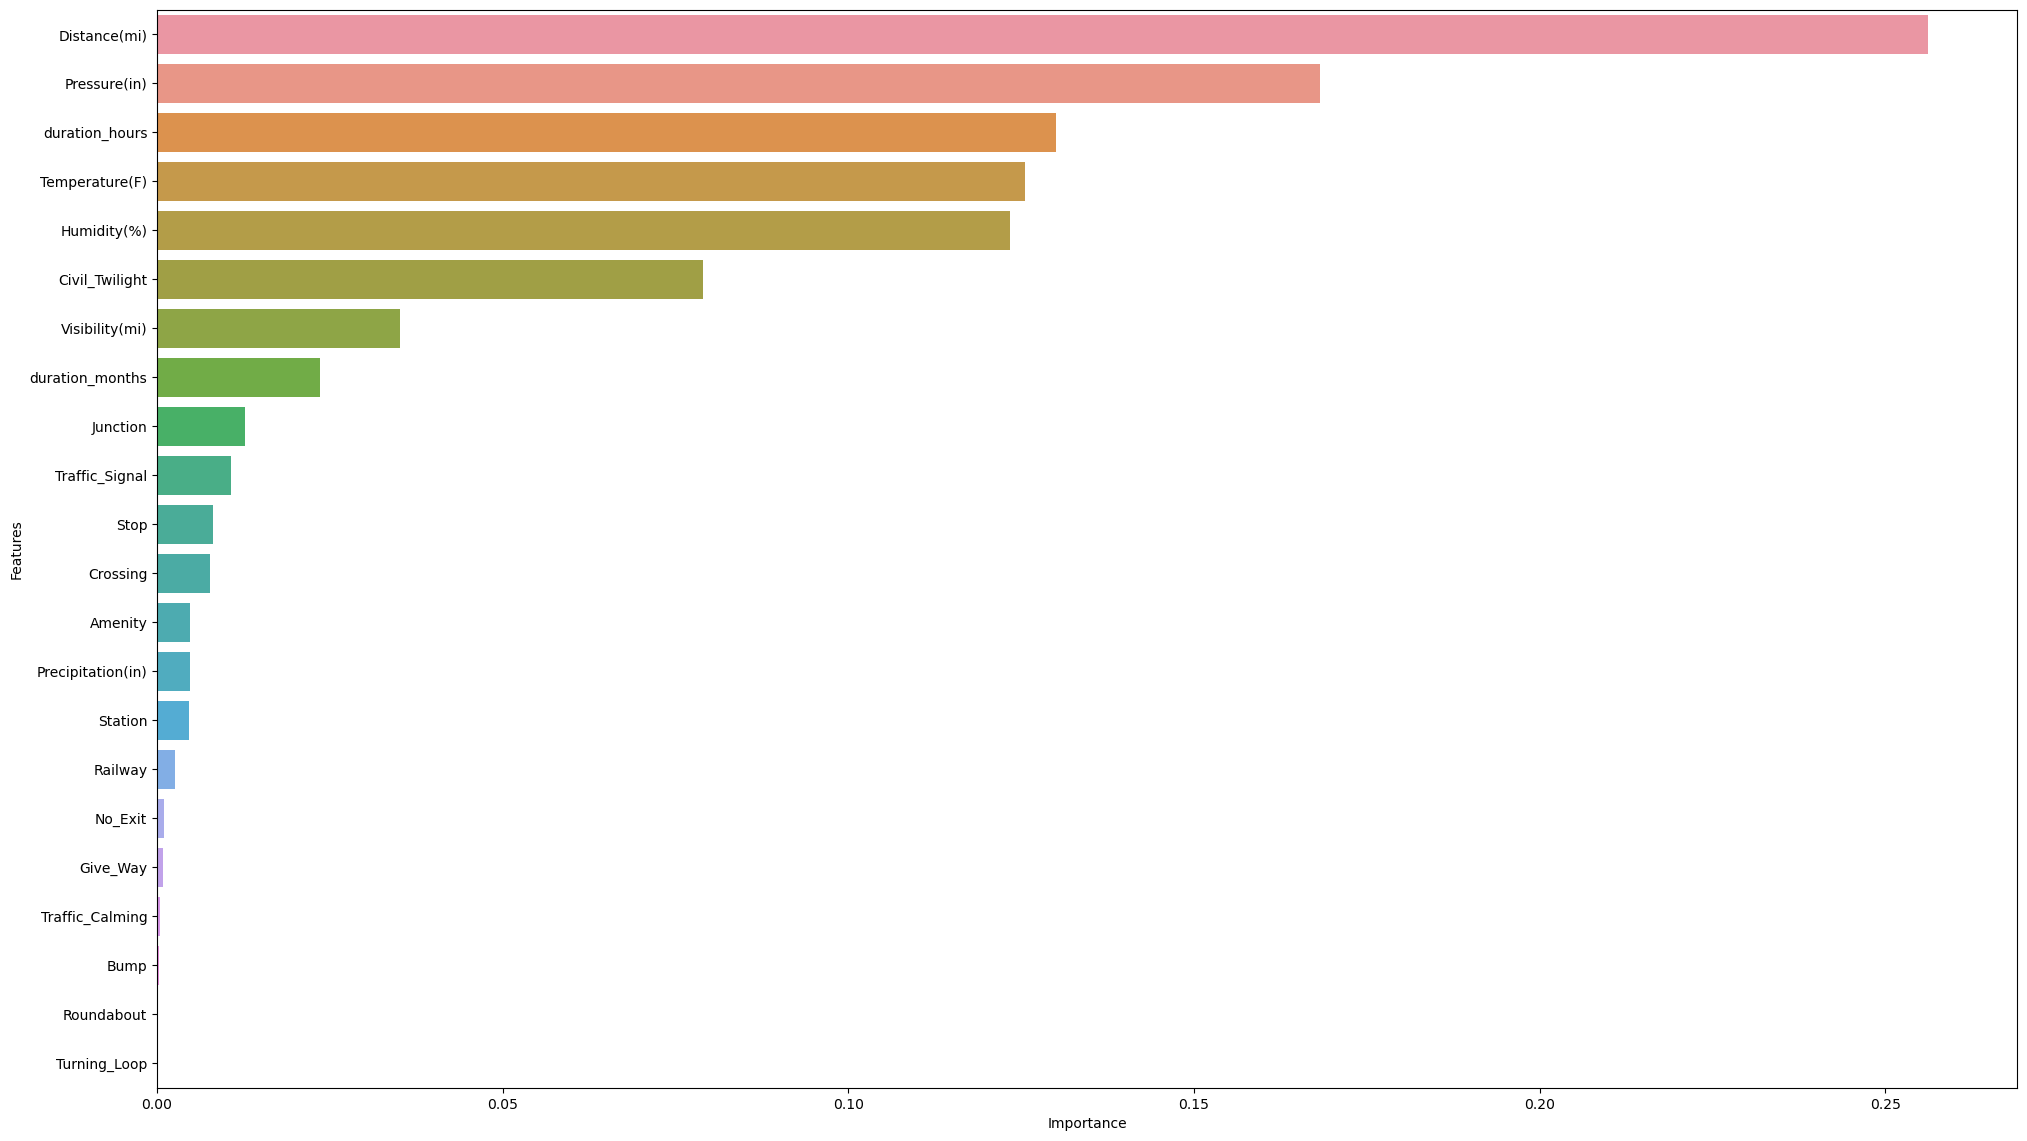

In [67]:
%%time
# ---------------------------------RANDOM FOREST ANALYSIS---------------------------------
rfc = RandomForestClassifier(n_estimators=340)
rfc.fit(X,y)
importances = rfc.feature_importances_
# Df to store and plot results
scores_df = pd.DataFrame({'Features':pd.DataFrame(X).columns,'Importance':importances})
scores_df.set_index('Importance')
scores_df=scores_df.sort_values(by='Importance',ascending=False)
plt.figure(figsize=(24,14))
sns.barplot(x=scores_df['Importance'],y=scores_df['Features'])
# plt.barh(scores_df['Importance'],scores_df['Features'])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Random Forest Analysis')
# plt.show()

In [68]:
features = list(scores_df[scores_df['Importance']>=0.009]['Features'])
print(features)

['Distance(mi)', 'Pressure(in)', 'duration_hours', 'Temperature(F)', 'Humidity(%)', 'Civil_Twilight', 'Visibility(mi)', 'duration_months', 'Junction', 'Traffic_Signal']


### Baseline Random Forest Classifier

In [69]:
rfc_base = RandomForestClassifier(n_estimators=200)
rfc_base.fit(X_train[features],y_train)


RandomForestClassifier(n_estimators=200)

In [70]:
y_pred = rfc_base.predict(X_test[features])


In [71]:

# from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

NameError: name 'classification_report' is not defined

In [ ]:
# from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test,y_pred))

In [ ]:
# ------------------------------------Current Highest----------------------------------------------
# n_estimators = 200, duration_hours included
print(classification_report(y_test,y_pred))

In [ ]:
y_proba_rfc = rfc_base.predict_proba(X_test[features])[::,-1] # 200 trees
rfc_fpr, rfc_tpr,_ = metrics.roc_curve(y_test,y_proba_rfc)
auc_rfc = roc_auc_score(y_test,y_proba_rfc)
plt.plot(rfc_fpr, rfc_tpr, label = f'Random Forest auc = {auc_rfc:.3f}' )
plt.plot(rfc_fpr, rfc_fpr, 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
# y_proba_svm = model_SVC.predict_proba(X_test)[::,-1]

In [ ]:
# ------------------------------------Current Highest----------------------------------------------
# n_estimators = 200, duration_hours included
print('ROC-AUC score:',roc_auc_score(y_test,y_pred))
print('Accuracy score:',metrics.accuracy_score(y_test,y_pred))